Bejing Air Quality Evaluation

# Setup

In [ ]:
import os
import glob
import numpy as np # linear algebra
import random
import json
import joblib

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential, optimizers, metrics
from tensorflow.keras import regularizers
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras import regularizers
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.decomposition import PCA

In [ ]:
SEQUENCE_LEN = 5
BATCH_SIZE = 128
PM_25_BOUNDARIES = [35, 75, 150]
NUM_CLASSES = len(PM_25_BOUNDARIES) + 1
NUM_COLS = 16
batch_size = BATCH_SIZE

# PM 2.5 categorisation project

This project looks at the weather recording stations data around Beijing it then uses various machine learning methods to predict PM2.5 concentrations, this notebook is the *Evaluation* notebook.

it does this by classifying them into four categories:

<=35

36-75

76-150

,>151

The evaluations in this notebook are from the PM2.5 categorisation project.

data used is:

In [ ]:
# Load the dataset
base_dir = '/datasets/beijing-air/normalised'
datafiles = glob.glob(base_dir + '/*.csv')
datafiles

['/datasets/beijing-air/normalised/PRSA_Data_Gucheng_20130301-20170228.csv',
 '/datasets/beijing-air/normalised/PRSA_Data_Dongsi_20130301-20170228.csv',
 '/datasets/beijing-air/normalised/PRSA_Data_Aotizhongxin_20130301-20170228.csv',
 '/datasets/beijing-air/normalised/PRSA_Data_Nongzhanguan_20130301-20170228.csv',
 '/datasets/beijing-air/normalised/PRSA_Data_Wanshouxigong_20130301-20170228.csv',
 '/datasets/beijing-air/normalised/PRSA_Data_Wanliu_20130301-20170228.csv',
 '/datasets/beijing-air/normalised/PRSA_Data_Dingling_20130301-20170228.csv',
 '/datasets/beijing-air/normalised/PRSA_Data_Changping_20130301-20170228.csv',
 '/datasets/beijing-air/normalised/PRSA_Data_Tiantan_20130301-20170228.csv',
 '/datasets/beijing-air/normalised/PRSA_Data_Shunyi_20130301-20170228.csv',
 '/datasets/beijing-air/normalised/PRSA_Data_Guanyuan_20130301-20170228.csv',
 '/datasets/beijing-air/normalised/PRSA_Data_Huairou_20130301-20170228.csv']

Datasets:

The normalised data was batched and windowed, then PCA batched data was created. The regular data was then extracted to numpy data there was a 70-20-10 split of training, validation and test data.

Models:

lstm_base: the baseline lstm model

lstm_pca: a lstm model with pca

lstm_deep: a deeper model with dropout layers

rfp: a regular randomforest with default parameters

rfh: random_forest with changed hyper-paramters

lstm_final: a lstm on the test data

# Gather valid, test data

In [ ]:
train_datafiles = datafiles[:7]
validation_datafiles = datafiles[7:9]
test_datafiles = datafiles[9:]
train_datafiles, validation_datafiles, test_datafiles

(['/datasets/beijing-air/normalised/PRSA_Data_Gucheng_20130301-20170228.csv',
  '/datasets/beijing-air/normalised/PRSA_Data_Dongsi_20130301-20170228.csv',
  '/datasets/beijing-air/normalised/PRSA_Data_Aotizhongxin_20130301-20170228.csv',
  '/datasets/beijing-air/normalised/PRSA_Data_Nongzhanguan_20130301-20170228.csv',
  '/datasets/beijing-air/normalised/PRSA_Data_Wanshouxigong_20130301-20170228.csv',
  '/datasets/beijing-air/normalised/PRSA_Data_Wanliu_20130301-20170228.csv',
  '/datasets/beijing-air/normalised/PRSA_Data_Dingling_20130301-20170228.csv'],
 ['/datasets/beijing-air/normalised/PRSA_Data_Changping_20130301-20170228.csv',
  '/datasets/beijing-air/normalised/PRSA_Data_Tiantan_20130301-20170228.csv'],
 ['/datasets/beijing-air/normalised/PRSA_Data_Shunyi_20130301-20170228.csv',
  '/datasets/beijing-air/normalised/PRSA_Data_Guanyuan_20130301-20170228.csv',
  '/datasets/beijing-air/normalised/PRSA_Data_Huairou_20130301-20170228.csv'])

In [ ]:
def load_and_chain_ds(filenames):
    base_ds = tf.data.experimental.make_csv_dataset(
        filenames[0],
        batch_size=BATCH_SIZE,
        label_name='PM2.5',
        shuffle=False, num_epochs=1,
        )
    for f in filenames[1:]:
        d = tf.data.experimental.make_csv_dataset(
            f,
            batch_size=BATCH_SIZE,
            label_name='PM2.5',
            shuffle=False, num_epochs=1,
            )
        base_ds = base_ds.concatenate(d)
    base_ds = base_ds.cache()
    base_ds = base_ds.prefetch(tf.data.AUTOTUNE)
    return base_ds

In [ ]:
train_ds = load_and_chain_ds(train_datafiles)
validation_ds = load_and_chain_ds(validation_datafiles)
test_ds = load_and_chain_ds(test_datafiles)

In [ ]:
pm25_categories = Discretization(bin_boundaries=PM_25_BOUNDARIES, output_mode='one_hot')

@tf.function
def merge_cols(x):
    inputs = tf.convert_to_tensor(list(x.values()))
    return tf.transpose(inputs)

In [ ]:
train_ds = train_ds.map(lambda x, y: (
    merge_cols(x), pm25_categories(y)))

validation_ds = validation_ds.map(lambda x, y: (
    merge_cols(x), pm25_categories(y)))

test_ds = test_ds.map(lambda x, y: (
    merge_cols(x), pm25_categories(y)))

test_ds

<MapDataset element_spec=(TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [ ]:
def extract_features(dataset):
    """
    Extracts features and target labels from a batched dataset and then converts them to NumPy arrays

    Parameters:
        dataset (tf.data.Dataset) - A batched dataset.

    Returns:
        tuple: A tuple (X, y) X being the features and y being the labels
    """
    X_ds = dataset.map(lambda x, y: x)
    y_ds = dataset.map(lambda x, y: y)
    X = next(iter(X_ds))
    y = next(iter(y_ds))
    X = np.concatenate(list(X_ds.as_numpy_iterator()))    #this converts my data to a numpy X_train, y_train etc.. for rf
    y = np.concatenate(list(y_ds.as_numpy_iterator()))
    return X, y

In [ ]:
def windowify(dataset, window_size=SEQUENCE_LEN, batch_size=BATCH_SIZE):
    fds = dataset.unbatch().window(window_size, shift=1)
    fds_x = fds.flat_map(
        lambda x, y: x.batch(window_size, drop_remainder=True))
    fds_y = fds.flat_map(
        lambda x, y: y.batch(window_size, drop_remainder=True))
    fds_y = fds_y.map(lambda y: y[-1, :])
    fds = tf.data.Dataset.zip((fds_x, fds_y))
    fds = fds.shuffle(1000)
    fds = fds.cache()
    fds = fds.batch(batch_size)
    return fds

In [ ]:
train_ds = windowify(train_ds)
validation_ds = windowify(validation_ds)   # this is data that has no pca
test_ds = windowify(test_ds)
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 5, 16), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

# Create X, y data

In [ ]:
X_train, y_train = extract_features(train_ds)
X_test, y_test = extract_features(test_ds)
X_valid, y_valid = extract_features(validation_ds)

In [ ]:
X_train.shape, y_train.shape

((222475, 5, 16), (222475, 4))

# Apply PCA

In [ ]:
X_train_flat = np.reshape(X_train, (-1, X_train.shape[-1]))
X_valid_flat = np.reshape(X_valid, (-1, X_valid.shape[-1]))
X_test_flat = np.reshape(X_test, (-1, X_test.shape[-1]))

In [ ]:
pca = PCA(n_components=15)
pca.fit(X_train_flat)

X_transformed = pca.transform(X_train_flat)
X_valid_transformed = pca.transform(X_valid_flat)
X_test_transformed = pca.transform(X_test_flat)

In [ ]:
X_transformed = np.reshape(X_transformed, (X_train.shape[0], X_train.shape[1], -1))
X_valid_transformed = np.reshape(X_valid_transformed, (X_valid.shape[0], X_valid.shape[1], -1))
X_test_transformed = np.reshape(X_test_transformed, (X_test.shape[0], X_test.shape[1], -1))

In [ ]:
import tensorflow as tf

def my_generator():
    for i in range(len(X_transformed)):
        yield X_transformed[i], y_train[i]


dataset = tf.data.Dataset.from_generator(
    lambda: my_generator(),
    output_types=(tf.float32, tf.float32),
    output_shapes=((SEQUENCE_LEN, X_transformed.shape[2]), (NUM_CLASSES,)) # this was code i was messing with to get the function below working
)
dataset = dataset.shuffle(buffer_size=1000)
dataset = dataset.batch(batch_size)


In [ ]:
def create_dataset(X, y, shuffle=True, cache=True):
    """
    Creates a TensorFlow dataset from the given input and target. As i couldn't get TF slices method of batching data
    to work.

    Args:
        X (np.ndarray): Input array of windowed data with shape (num_samples, sequence_length, num_features).
        y (np.ndarray): Target array with shape (num_samples, num_classes).
        shuffle (bool, optional): Whether to shuffle the data. Defaults to True.
        cache (bool, optional): Whether to cache the dataset in memory. Defaults to True.

    Returns:
        tf.data.Dataset: A TF dataset object containing the input and target data.
    """
    def my_generator():
        for i in range(len(X)):
            yield X[i], y[i]

    dataset = tf.data.Dataset.from_generator(
        lambda: my_generator(),
        output_types=(tf.float32, tf.float32),
        output_shapes=((SEQUENCE_LEN, X.shape[2]), (NUM_CLASSES,))
    )

    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)

    if cache:
        dataset = dataset.cache()

    dataset = dataset.batch(batch_size)

    return dataset

In [ ]:
train_ds_pca = create_dataset(X_transformed, y_train)
valid_ds_pca = create_dataset(X_valid_transformed, y_valid) #create batched datasets for pca data
test_ds_pca = create_dataset(X_test_transformed, y_test)

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_valid = np.reshape(X_valid, (X_valid.shape[0], -1))  #reshape data so its suitable for RF
X_test = np.reshape(X_test, (X_test.shape[0], -1))

In [ ]:
train_ds_pca

<BatchDataset element_spec=(TensorSpec(shape=(None, 5, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [ ]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 5, 16), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

# Evaluation

In [ ]:
# avoid tripping up with generic global variables used in sample code
model = None
history = None

# LSTM_BASE Model Evaluation

In [ ]:
lstm_base = tf.keras.models.load_model('lstm_base.h5')
with open('lstm_base.json') as f:
    lstm_base_history = json.load(f)

In [ ]:
lstm_base.evaluate(train_ds, return_dict=True) # train evaluation

1739/1739 [==============================] - 33s 18ms/step - loss: 0.4311 - accuracy: 0.8279


{'loss': 0.4311191141605377, 'accuracy': 0.8278548121452332}

In [ ]:
lstm_base.evaluate(validation_ds, return_dict=True) # validation evaluation

512/512 [==============================] - 9s 17ms/step - loss: 0.3959 - accuracy: 0.8370


{'loss': 0.3959138095378876, 'accuracy': 0.8370115756988525}

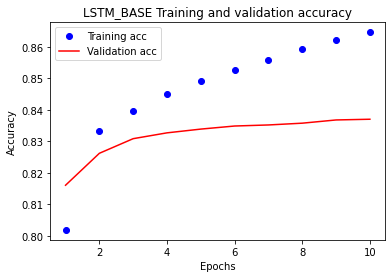

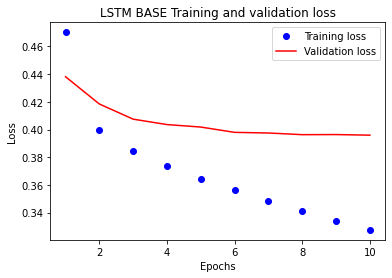

In [ ]:
train_acc = lstm_base_history['accuracy']
val_acc = lstm_base_history['val_accuracy']
train_loss = lstm_base_history['loss']
val_loss = lstm_base_history['val_loss']
plt.show()

epochs = range(1, len(train_acc)+1)
plt.plot(epochs, train_acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('LSTM_BASE Training and validation accuracy')
plt.legend() # show legend
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

plt.plot(epochs, train_loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('LSTM BASE Training and validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
y_pred_probs = lstm_base.predict(validation_ds)


y_pred = np.argmax(y_pred_probs, axis=1)


y_true = np.concatenate([y for x, y in validation_ds], axis=0)
y_true = np.argmax(y_true, axis=1)


class_report = classification_report(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred_probs, multi_class='ovr')
print("\n")

print("AUC:", auc)
print("\n")
print("Class report:\n", class_report)
print("\n")
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))




AUC: 0.9678483121826205


Class report:
               precision    recall  f1-score   support

           0       0.93      0.88      0.91     25038
           1       0.71      0.77      0.74     15691
           2       0.82      0.78      0.80     15377
           3       0.85      0.93      0.89      9414

    accuracy                           0.84     65520
   macro avg       0.83      0.84      0.83     65520
weighted avg       0.84      0.84      0.84     65520



Confusion Matrix:
 [[22051  2921    56    10]
 [ 1578 12098  1991    24]
 [   25  1896 11944  1512]
 [    9    27   630  8748]]


Lets make the confusion matrix a bit nicer

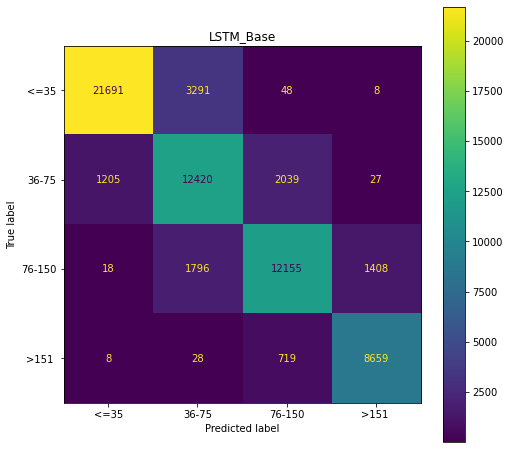

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# creates confusion matrix obk
cm = confusion_matrix(y_true, y_pred)

# Displays it
display_labels = ['<=35', '36-75', '76-150', '>151 ']
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title("LSTM_Base")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(ax=ax);
plt.show()


# LSTM_PCA Model Evaluation

In [ ]:
lstm_pca = tf.keras.models.load_model('lstm_pca.h5')
with open('lstm_pca.json') as f:
    lstm_pca_history = json.load(f)

In [ ]:
lstm_pca.evaluate(train_ds_pca, return_dict=True) # train evaluation

1739/1739 [==============================] - 25s 14ms/step - loss: 0.3922 - accuracy: 0.8458


{'loss': 0.39223140478134155, 'accuracy': 0.8458253741264343}

In [ ]:
lstm_pca.evaluate(valid_ds_pca, return_dict=True) # validation evaluation

512/512 [==============================] - 7s 14ms/step - loss: 0.3787 - accuracy: 0.8481


{'loss': 0.37867075204849243, 'accuracy': 0.8481074571609497}

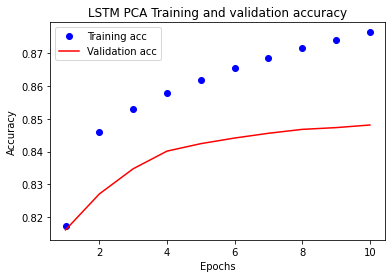

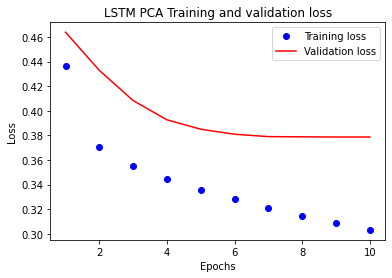

In [ ]:
train_acc = lstm_pca_history['accuracy']
val_acc = lstm_pca_history['val_accuracy']
train_loss = lstm_pca_history['loss']
val_loss = lstm_pca_history['val_loss']
plt.show()

epochs = range(1, len(train_acc)+1)
plt.plot(epochs, train_acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('LSTM PCA Training and validation accuracy')
plt.legend() # show legend
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

plt.plot(epochs, train_loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('LSTM PCA Training and validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
y_pred_probs = lstm_pca.predict(valid_ds_pca)


y_pred = np.argmax(y_pred_probs, axis=1)


y_true = np.concatenate([y for x, y in valid_ds_pca], axis=0)
y_true = np.argmax(y_true, axis=1)


class_report = classification_report(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred_probs, multi_class='ovr')
print("\n")
# display results
print("AUC:", auc)
print("\n")
print("Class report:\n", class_report)




AUC: 0.9705235594266247


Class report:
               precision    recall  f1-score   support

           0       0.91      0.92      0.92     25038
           1       0.75      0.75      0.75     15691
           2       0.81      0.81      0.81     15377
           3       0.89      0.89      0.89      9414

    accuracy                           0.85     65520
   macro avg       0.84      0.84      0.84     65520
weighted avg       0.85      0.85      0.85     65520



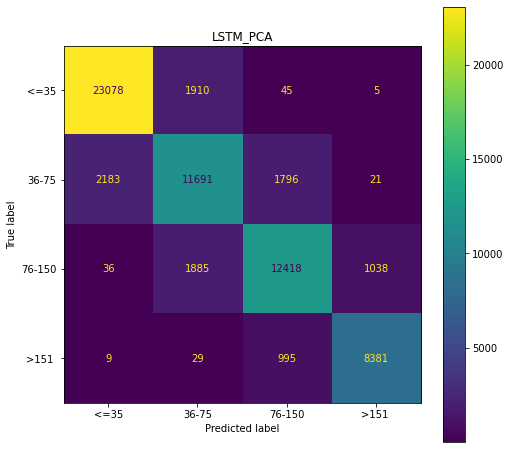

In [ ]:
cm = confusion_matrix(y_true, y_pred)

display_labels = ['<=35', '36-75', '76-150', '>151 ']
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title("LSTM_PCA")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(ax=ax, values_format = '.0f');
plt.show()


# LSTM_DEEP Model Evaluation

In [ ]:
lstm_deep = tf.keras.models.load_model('lstm_deep.h5')
with open('lstm_deep.json') as f:
    lstm_deep_history = json.load(f)

In [ ]:
lstm_deep.evaluate(train_ds, return_dict=True) # train evaluation

1739/1739 [==============================] - 6s 3ms/step - loss: 0.4467 - accuracy: 0.8271


{'loss': 0.4467023015022278, 'accuracy': 0.8271041512489319}

In [ ]:
lstm_deep.evaluate(validation_ds, return_dict=True) # validation evaluation

512/512 [==============================] - 1s 3ms/step - loss: 0.3840 - accuracy: 0.8434


{'loss': 0.3840198516845703, 'accuracy': 0.843406617641449}

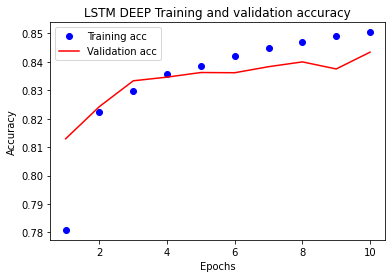

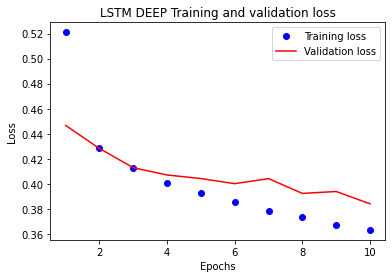

In [ ]:
train_acc = lstm_deep_history['accuracy']
val_acc = lstm_deep_history['val_accuracy']
train_loss = lstm_deep_history['loss']
val_loss = lstm_deep_history['val_loss']
plt.show()

epochs = range(1, len(train_acc)+1)
plt.plot(epochs, train_acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('LSTM DEEP Training and validation accuracy')
plt.legend() # show legend
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

plt.plot(epochs, train_loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('LSTM DEEP Training and validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
y_pred_probs = lstm_deep.predict(validation_ds)


y_pred = np.argmax(y_pred_probs, axis=1)

y_true = np.concatenate([y for x, y in validation_ds], axis=0)
y_true = np.argmax(y_true, axis=1)

class_report = classification_report(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred_probs, multi_class='ovr')
print("\n")
print("AUC:", auc)
print("\n")
print("Class report:\n", class_report)



AUC: 0.9700822451624619


Class report:
               precision    recall  f1-score   support

           0       0.95      0.87      0.91     25038
           1       0.72      0.79      0.75     15691
           2       0.81      0.81      0.81     15377
           3       0.87      0.92      0.89      9414

    accuracy                           0.84     65520
   macro avg       0.84      0.85      0.84     65520
weighted avg       0.85      0.84      0.85     65520



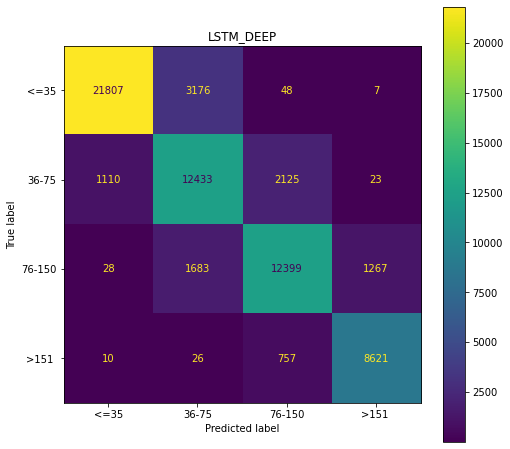

In [ ]:
cm = confusion_matrix(y_true, y_pred)


display_labels = ['<=35', '36-75', '76-150', '>151 ']
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title("LSTM_DEEP")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(ax=ax, values_format = '.0f');
plt.show()

# Plain RF model evaluation

In [ ]:
rfp = joblib.load('rfp_model.joblib')

In [ ]:
valid = rfp.score(X_valid, y_valid)
train = rfp.score(X_train, y_train)

print("Validation Accuracy:", valid)
print("Training Accuracy:", train)

Validation Accuracy: 0.8601190476190477
Training Accuracy: 0.9999910102258681


In [ ]:
y_pred = rfp.predict(X_valid)

report = classification_report(y_valid, y_pred)

auc_score = roc_auc_score(y_valid, y_pred)

print('AUC score:', auc_score)
print('\n')
print(report)

AUC score: 0.9099929961458271


              precision    recall  f1-score   support

           0       0.95      0.92      0.94     25038
           1       0.83      0.77      0.80     15691
           2       0.86      0.84      0.85     15377
           3       0.94      0.88      0.91      9414

   micro avg       0.90      0.86      0.88     65520
   macro avg       0.90      0.85      0.87     65520
weighted avg       0.90      0.86      0.88     65520
 samples avg       0.86      0.86      0.86     65520



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Convert multilabel targets to one-hot encoded format
y_valid_onehot = label_binarize(y_valid, classes=[0, 1, 2, 3]) # confusion matrix wasn't accepting y data before

y_pred = rfp.predict(X_valid)
y_pred = np.argmax(y_pred, axis=1)

conf_mat = confusion_matrix(y_valid_onehot.argmax(axis=1), y_pred)


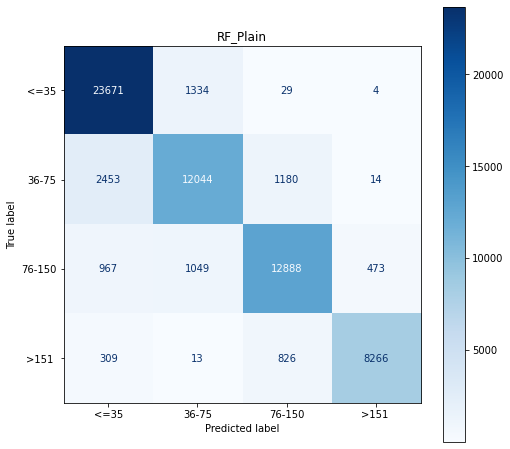

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                              display_labels=display_labels)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title("RF_Plain")
plt.show()

 # hyperparameter RF model evaluation

In [ ]:
rfh = joblib.load('rfh_model.joblib')

In [ ]:
valid = rfh.score(X_valid, y_valid)
train = rfh.score(X_train, y_train)

print("Validation Accuracy:", valid)
print("Training Accuracy:", train)

Validation Accuracy: 0.8646978021978022
Training Accuracy: 0.99927632318238


In [ ]:
y_pred = rfh.predict(X_valid)

report = classification_report(y_valid, y_pred)
auc_score = roc_auc_score(y_valid, y_pred)

print('AUC score:', auc_score)
print('\n')

print(report)

AUC score: 0.9118866062336127


              precision    recall  f1-score   support

           0       0.95      0.93      0.94     25038
           1       0.83      0.78      0.80     15691
           2       0.86      0.85      0.85     15377
           3       0.94      0.88      0.91      9414

   micro avg       0.90      0.86      0.88     65520
   macro avg       0.90      0.86      0.88     65520
weighted avg       0.90      0.86      0.88     65520
 samples avg       0.86      0.86      0.86     65520



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
y_valid_onehot = label_binarize(y_valid, classes=[0, 1, 2, 3]) # confusion matrix wasn't accepting y data before


y_pred = rfh.predict(X_valid)
y_pred = np.argmax(y_pred, axis=1)


conf_mat = confusion_matrix(y_valid_onehot.argmax(axis=1), y_pred)

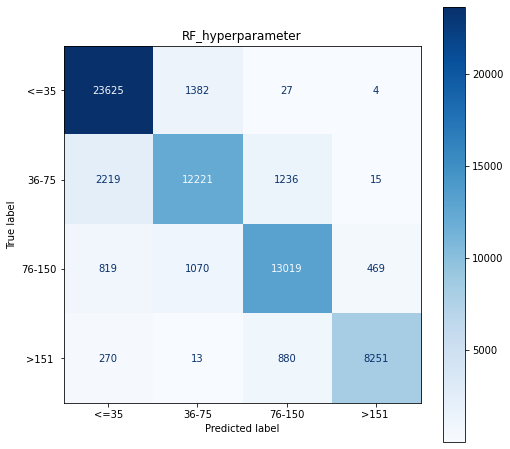

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                              display_labels=display_labels)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title("RF_hyperparameter")
plt.show()

# LSTM Final On Test with all three methods Data Evaluation

In [ ]:
lstm_final = tf.keras.models.load_model('lstm_final.h5')
with open('lstm_final.json') as f:
    lstm_final_history = json.load(f)

In [ ]:
lstm_final.evaluate(train_ds_pca, return_dict=True) # train evaluation

1739/1739 [==============================] - 5s 3ms/step - loss: 0.3944 - accuracy: 0.8495


{'loss': 0.39435845613479614, 'accuracy': 0.8495156764984131}

In [ ]:
lstm_final.evaluate(test_ds_pca, return_dict=True) # test evaluation

736/736 [==============================] - 11s 14ms/step - loss: 0.4051 - accuracy: 0.8467


{'loss': 0.4050832688808441, 'accuracy': 0.8467093706130981}

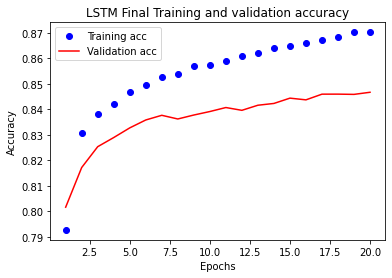

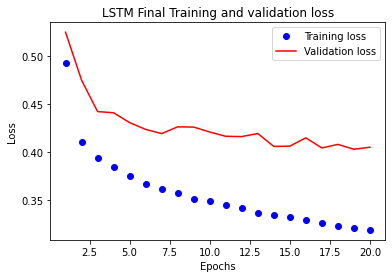

In [ ]:
train_acc = lstm_final_history['accuracy']
val_acc = lstm_final_history['val_accuracy']
train_loss = lstm_final_history['loss']
val_loss = lstm_final_history['val_loss']
plt.show()

epochs = range(1, len(train_acc)+1)
plt.plot(epochs, train_acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('LSTM Final Training and validation accuracy')
plt.legend() # show legend
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

plt.plot(epochs, train_loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('LSTM Final Training and validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
y_pred_probs = lstm_final.predict(test_ds_pca)

y_pred = np.argmax(y_pred_probs, axis=1)

y_true = np.concatenate([y for x, y in test_ds_pca], axis=0)
y_true = np.argmax(y_true, axis=1)

class_report = classification_report(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred_probs, multi_class='ovr')
print("\n")
# display results
print("AUC:", auc)
print("\n")
print("Class report:\n", class_report)



AUC: 0.9690751955412787


Class report:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92     35267
           1       0.77      0.72      0.75     22538
           2       0.80      0.81      0.80     22532
           3       0.86      0.92      0.88     13824

    accuracy                           0.85     94161
   macro avg       0.84      0.84      0.84     94161
weighted avg       0.85      0.85      0.85     94161



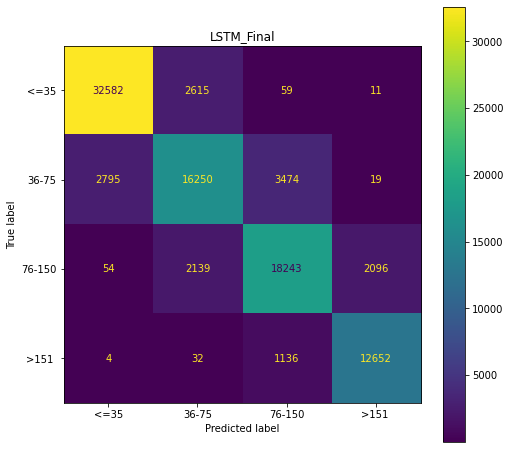

In [ ]:
cm = confusion_matrix(y_true, y_pred)


display_labels = ['<=35', '36-75', '76-150', '>151 ']
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title("LSTM_Final")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(ax=ax, values_format = '.0f');
plt.show()